### Introduction
Making a disease diagnosis from a sample of tissue (Pathology) is part art/part science. It relies on quantitative metrics such as counts of scores of miss-formed cell morphology, but also on a final subjective decision by the physician. This decision may or may not be formed from a objective weighting of the quantitative metrics. 

### My Investigation
To gain insight into this decision, I anaylzed data from the wisconsin breast cancer database and compared the conclusions of the pathologist with the results of machine learning algorithims: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original). 

### Hypothesis
By inspecting the feature space, and visually comparing this to the diagnosis labels, I found that the pathological assessment appears to be formed from a roughly linear combination of the recorded cytological features. To test this I built a machine learning classifier and compared its performance to the results of the pathologist. The accuracy, precision and recall of this the logistic model were all very high. To gain further insight I identify the misclassified data and suggest they be re-inspected by the pathologist to determine the traits that distinguish them.
### Findings

### Recommendation

In [208]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

In [209]:
columns = ["id", "clump_thickness", "cell_size", "cell_shape", "marginal_adhesion", 
           "epithelial_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]

data = pd.read_csv("breast-cancer-wisconsin.data.csv", names=columns)
data.head(10)

id  clump_thickness  cell_size  cell_shape  marginal_adhesion  \
0  1000025                5          1           1                  1   
1  1002945                5          4           4                  5   
2  1015425                3          1           1                  1   
3  1016277                6          8           8                  1   
4  1017023                4          1           1                  3   
5  1017122                8         10          10                  8   
6  1018099                1          1           1                  1   
7  1018561                2          1           2                  1   
8  1033078                2          1           1                  1   
9  1033078                4          2           1                  1   

   epithelial_cell_size bare_nuclei  bland_chromatin  normal_nucleoli  \
0                     2           1                3                1   
1                     7          10                3                2   
2                     2           2                3                1   
3                     3           4                3                7   
4                     2           1                3                1   
5                     7          10                9                7   
6                     2          10                3                1   
7                     2           1                3                1   
8                     2           1                1                1   
9                     2           1                2                1   

   mitoses  class  
0        1      2  
1        1      2  
2        1      2  
3        1      2  
4        1      2  
5        1      4  
6        1      2  
7        1      2  
8        5      2  
9        1      2

In [210]:
labels = {2: 0, 4: 1}
data["class"] = data["class"].apply(lambda x: labels[x])
#data.head(50)

### Histogram every feature

It looks like for all the predictors the data span the full range from 0 to 10. and the distributions are similar (except for bland_chromatin, clump_thickness)

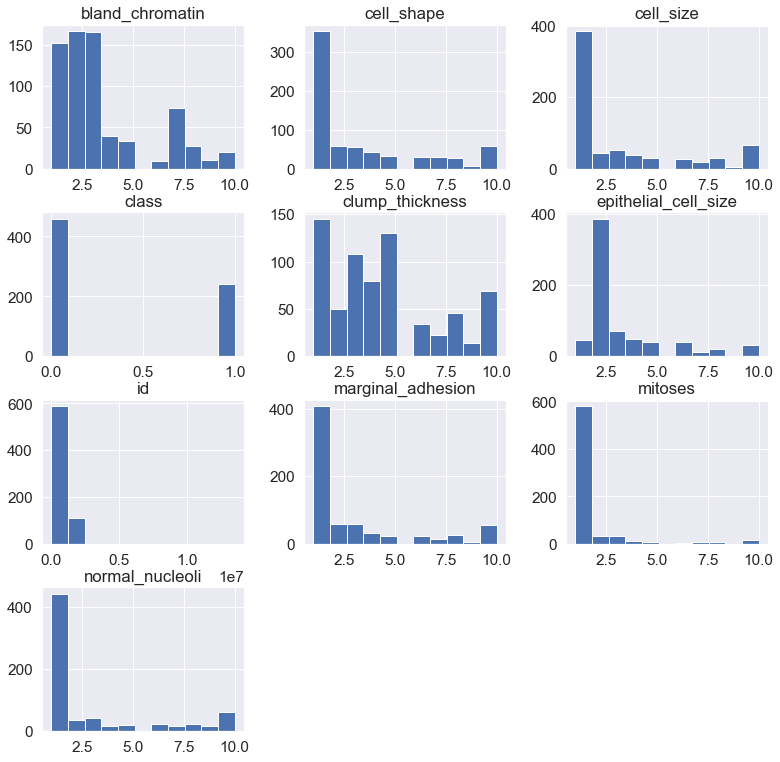

In [211]:
# data.describe()
hist = data.hist(bins=11, figsize=(13, 13))

Next I want to see if any of the data look like they are correlated, have other non-linear relationships or have strongly non-normal distributions. Since the number of features is relatively low, its easy to visualize this in a scatter-matrix plot.

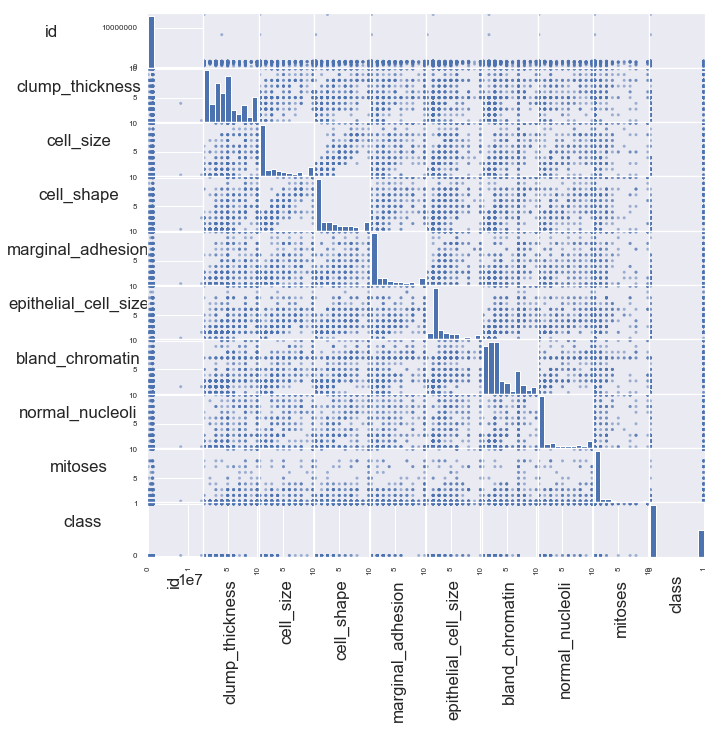

In [212]:
#fig = plt.figure(figsize = (20,20))
plts = pd.plotting.scatter_matrix(data,figsize = (10,10))

for x in range(len(plts)):
    for y in range(len(plts)):
        # to get the axis of subplots
        ax = plts[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

It looks like there are a few pairwise correlations between a couple of features e.g. (cell Size and cell shape). Most of the variables have a preponderance of '1s' but are otherwise rather evenly spread across the remaining 2-10 range. Since most feature scaling won't do anything to redistribute data out of the 1's bucket it's better to leave the data as is. The exception perhaps being 'Mitosis' that has a bit of a tail but most models should be fairly robust to this small amount of skew, so I'll proceed without rescaling the features.

### Data Cleaning

In [213]:
#sns.pairplot(data)
data["bare_nuclei"]= data["bare_nuclei"].replace('?', np.nan)
data["bare_nuclei"]= data.fillna(data["bare_nuclei"].median())
data["bare_nuclei"]= data.bare_nuclei.astype('int64')
data.dtypes

id                      int64
clump_thickness         int64
cell_size               int64
cell_shape              int64
marginal_adhesion       int64
epithelial_cell_size    int64
bare_nuclei             int64
bland_chromatin         int64
normal_nucleoli         int64
mitoses                 int64
class                   int64
dtype: object

### How many of each class?

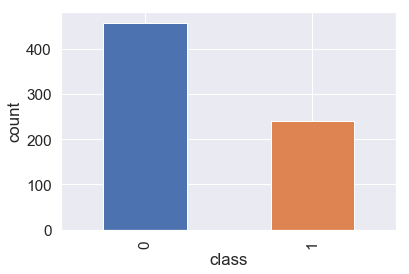

In [214]:
counts = data["class"].value_counts()
counts.plot(kind = "bar");
plt.xlabel("class");
plt.ylabel("count");

In [215]:
def make_features(data):
    """extract the features from the pandas dataframe 
    and convert it into a nxm matrix of m observations
    of n features. I am wrapping this in a function
    so to encapsulate my feature engineering here."""
    X =  np.vstack((data.clump_thickness,
                     data.cell_shape,
                     data.marginal_adhesion,
                     data.epithelial_cell_size,
                     data.bland_chromatin,
                     data.normal_nucleoli,
                     data.mitoses)).T
    return np.sqrt(X)

To evaluate what sort of modeling might be need it's worth first looking at a low dimentional projection of the data using PCA to see how the class I am predicting is distributed.

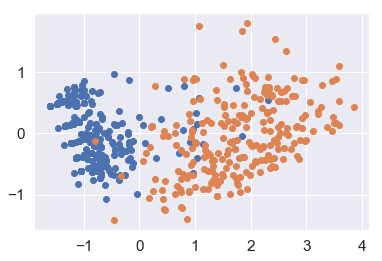

In [216]:
from sklearn.decomposition import PCA

X = make_features(data)
y = data["class"]
pca = PCA()
pca.fit(X)
X_low = pca.transform(X)

plt.plot(X_low[:,0][y == 0],X_low[:,1][y == 0],'o')
plt.plot(X_low[:,0][y == 1],X_low[:,1][y == 1],'o')

### Modeling
It looks like a linear decision boundary should do a fairly good job. I will now approach this as a supervised machine learning problem to predict the class y from the data X, because the data look roughly linearly separable I'll start with a simple logistic regression model.

### Baseline: Logistic Regression 

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler

X = data.drop(["id", "class"], axis = 1).as_matrix()
y = data["class"]

# Illustrated here for manual splitting of training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standarize features
#scaler = StandardScaler()
#X_train= scaler.fit_transform(X_train)
#X_test= scaler.transform(X_test)

# define method
logreg= LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='newton-cg')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)

# Use score method to get accuracy of model
score = logreg.score(X_train, y_train)
print('model train accuracy:', score)

# Use cross_val_score to automatically split, fit, and score.
scores = cross_val_score(logreg, X_train, y_train, cv=10)
#print(scores)
print('model cross vaildation accuracy:{}'.format(scores.mean()))


#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size

#classes =[-2, 0, 2]
y_pred = logreg.predict(X_test)
#cm_analysis(y_test, y_pred, classes, ymap=None, figsize=(8,8))

# Use score method to get accuracy of model
score = logreg.score(X_test, y_test)
print('model test accuracy: {}'.format(scores.mean()))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm d

model train accuracy: 0.964221824686941


/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not conve

model cross vaildation accuracy:0.9572915242652085
model test accuracy: 0.9572915242652085


/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [218]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

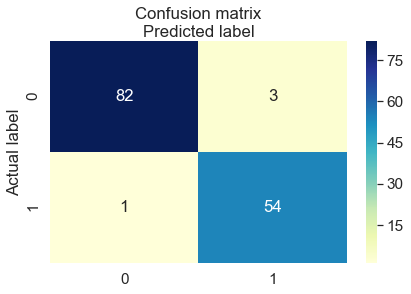

In [219]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [220]:
print("Accuracy", round(accuracy_score(y_test, y_pred) * 100, 3))
print("Precision", round(precision_score(y_test, y_pred) * 100, 3))
print("Recall", round(recall_score(y_test, y_pred) * 100, 3))

Accuracy 97.143
Precision 94.737
Recall 98.182


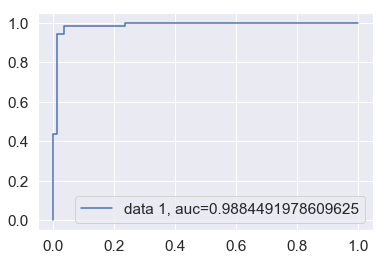

In [221]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Intrepretability

Now, i am looking to help the decision maker explain the features can contribute to the prediction.  I am using the package LIME to make sample-by-sample predictions.

In [226]:
import lime
import lime.lime_tabular
np.random.seed(1)

column_names = ["clump_thickness", "cell_size", "cell_shape", "marginal_adhesion", 
           "epithelial_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses"]
target_names = ['pathological', 'benign']

explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names= column_names, class_names= target_names, discretize_continuous=True)

for num in range(5):
    i = np.random.randint(0, test.shape[0])
    exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)
    exp.show_in_notebook(show_table=True, show_all= False)

Now, there is a lot going on here. First, note that the row we are explained is displayed on the right side, in table format. Since we had the show_all parameter set to false, only the features used in the explanation are displayed.

The value column displays the original value for each feature.

Note that LIME has discretized the features in the explanation. This is because we let discretize_continuous=True in the constructor (this is the default). Discretized features make for more intuitive explanations.

In [223]:
i

20